# UDF SEP Analysis Notebook (F105W, F125W, F160W)

In [121]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib import rcParams
rcParams['figure.figsize'] = [10,8]

## Load F105W Image

In [122]:
hdu = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')
data = hdu[0].data.astype(float)
hdu.close()
m, s = np.mean(data), np.std(data)

## Background subtraction and source extraction

In [123]:
bkg = sep.Background(data)
data_sub = data - bkg.back()
objects = sep.extract(data_sub, 1.5, err=bkg.rms())
num_sources = len(objects)
num_sources

6094

## Plot detected sources

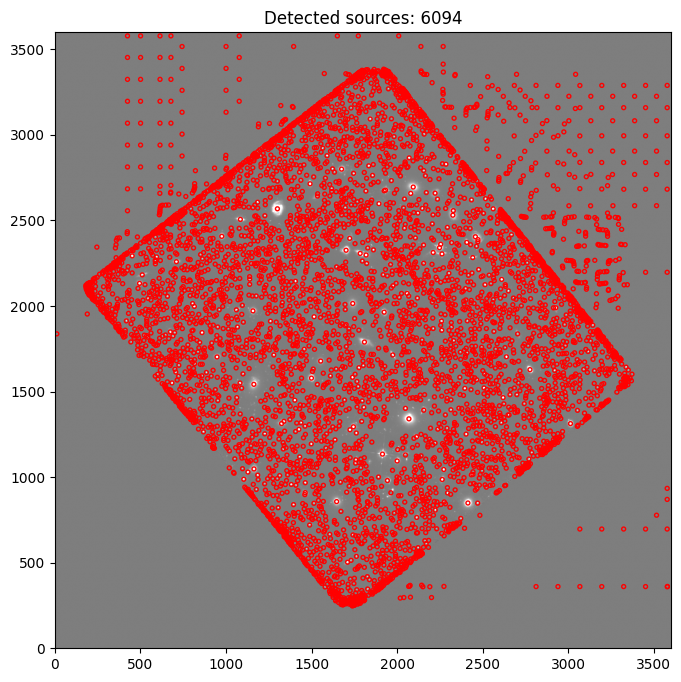

In [124]:
plt.imshow(data_sub, cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.scatter(objects['x'], objects['y'], s=8, edgecolors='red', facecolors='none')
plt.title(f'Detected sources: {num_sources}')
plt.savefig('fig_sources_udf_f105w.png', dpi=150)

## Aperture photometry for all sources

In [125]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], r=3.0,
                                     err=bkg.rms(), gain=1.0)

## Flux histogram

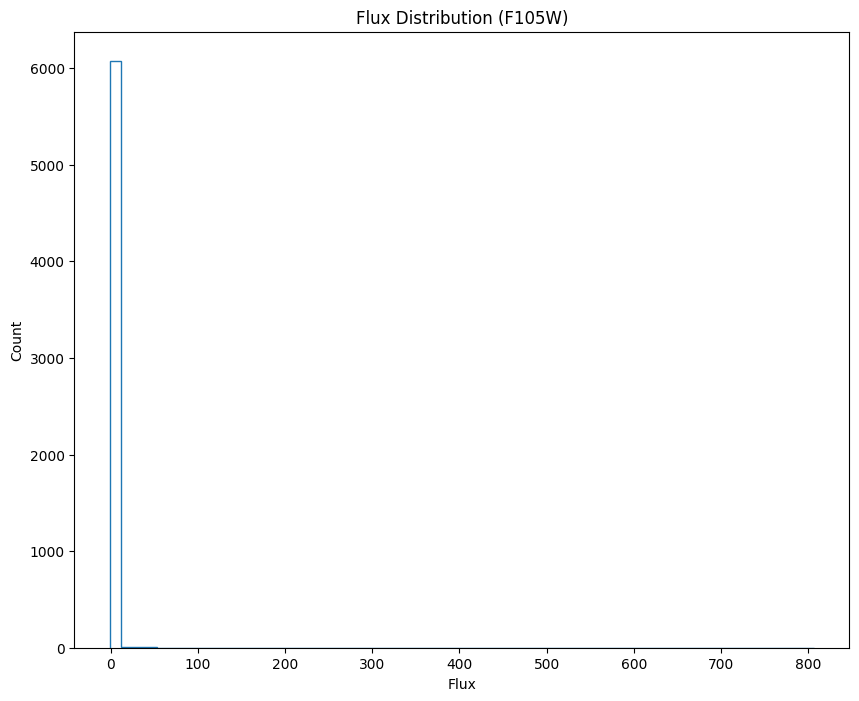

In [126]:
plt.hist(flux, bins=60, histtype='step')
plt.xlabel('Flux')
plt.ylabel('Count')
plt.title('Flux Distribution (F105W)')
plt.savefig('fig_flux_hist_f105w.png', dpi=150)

## Statistics and outlier identification

In [127]:
flux_mean = np.mean(flux)
flux_median = np.median(flux)
flux_std = np.std(flux)

# Find largest outlier
idx_out = np.argmax(flux)
out_flux = flux[idx_out]
out_x = objects['x'][idx_out]
out_y = objects['y'][idx_out]
out_sigma = (out_flux - flux_mean) / flux_std

flux_mean, flux_median, flux_std, out_flux, (out_x, out_y), out_sigma

(np.float64(0.4919560205213877),
 np.float64(0.03658150609087898),
 np.float64(10.99805679222476),
 np.float64(806.8106463623047),
 (np.float64(1914.2779597971667), np.float64(1134.3199666722003)),
 np.float64(73.31465054006834))

# Create RGB Composite (F160W = R, F125W = G, F105W = B)

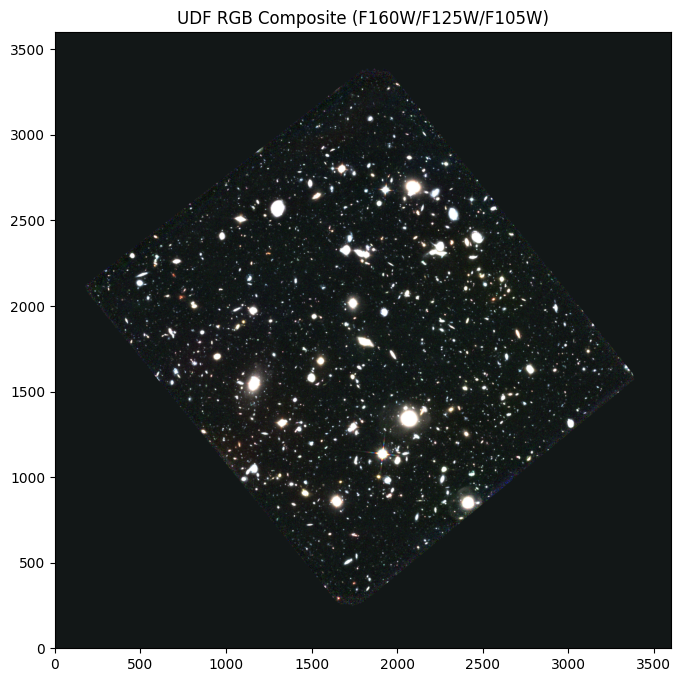

In [128]:
# Load three images
r = fits.getdata('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits').astype(float)
g = fits.getdata('hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits').astype(float)
b = data.astype(float)

def norm(im):
    im = im - np.percentile(im, 1)
    im = im / np.percentile(im, 99)
    im = np.clip(im, 0, 1)
    return im

R = norm(r)
G = norm(g)
B = norm(b)

rgb = np.dstack([R, G, B])

plt.imshow(rgb, origin='lower')
plt.title('UDF RGB Composite (F160W/F125W/F105W)')
plt.savefig('UDF_RGB_composite.png', dpi=200)